## 1. Import Library 

In [179]:
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, BatchNormalization, Dense,Dropout,LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import numpy as np
import pandas as pd
from pyvi import ViTokenizer
import regex as re
import string
np.set_printoptions(threshold=np.inf)

## 2. Data Proprocesing

#### 2.1. Read the file and divide it into sentences

In [180]:
def ReadData(path):
    df=pd.read_csv(path,encoding='utf-8')
    return df['comment']

> Execute Function

In [181]:
text_data = ReadData("../data/data_processed/generate.csv")

In [182]:
text_data[0:2]

0    Mới mua máy này Tại thegioididong thốt nốt cảm...
1    Pin kém còn lại miễn chê mua 8/3/2019 tình trạ...
Name: comment, dtype: object

### 2.2.Handle extra whitespace,line breaks, punctuation

In [183]:
def clear(comment):
  # Create a translation table
  translator = str.maketrans('', '', string.punctuation)
  # Remove punctuation
  new_string = comment.translate(translator)
  # Remove redudant space and break sign
  new_string = re.sub('[\n ]+', ' ', new_string)
  # Remove emoji icon
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags=re.UNICODE)
  new_string = re.sub(emoji_pattern, '', new_string)

  return new_string

> Execute Function

In [184]:
df_train=[]
for line in text_data:
    sentence=clear(line.lower())
    df_train.append(sentence)
df_train[0:2]

['mới mua máy này tại thegioididong thốt nốt cảm thấy ok bin trâu chụp ảnh đẹp loa nghe to bắt wf khỏe sóng ổn định giá thành vừa với túi tiền nhân viên tư vấn nhiệt tình',
 'pin kém còn lại miễn chê mua 832019 tình trạng pin còn 88 có ai giống tôi không']

### 2.3 Compound words with meaning

In [185]:
df_train_compound=[]
for line in df_train:
    sentence = ViTokenizer.tokenize(line)
    df_train_compound.append(sentence)

In [186]:
df_train_compound[0:10]

['mới mua máy này tại thegioididong thốt_nốt cảm_thấy ok bin trâu chụp ảnh đẹp loa nghe to bắt wf khỏe_sóng ổn_định giá_thành vừa với túi_tiền nhân_viên tư_vấn nhiệt_tình',
 'pin kém còn lại miễn chê mua 832019 tình_trạng pin còn 88 có ai giống tôi không',
 'sao lúc gọi điện_thoại màn_hình bị chấm nhỏ nháy gần camera trước vậylúc có lúc không',
 'mọi người cập_nhật phần_mềm lại nó sẽ bớt tốn pin mình đã thử rồi mọi thứ cũng ok nhưng vân tay ko nhạy',
 'mới mua sài được 1 tháng thấy pin rất trâu sài bao mượt nhưng có 1 lỗi nhỏ là mình nghe nhạc bằng tai_nghe nghe hơi lâu ko biết sao nó ko nghe được nữa mất rút tai_nghe_ra cắm vào lại thì nó mới nghe được',
 'xài tốt rất mượt pin trâu nếu các bạn để độ sáng vừa đủ nhân_viên nhiệt_tình vui_vẻ nói_chung là tầm giá này thì máy này là quá tốt rồi',
 'mình mới xài được 7 tháng xuống 7 pin chả hiểu máy mới kiểu gì nữa dùng cơ_bản lướt web cơ_bản game ko chơi',
 'hôm_qua_ngày 2362020 e ra thế_giới di_động mua chiếc dthoai galaxy a51 lúc đầu bên

#### 2.4  word separation

In [187]:
def wordseparation(comment):
    return [review.split() for review in comment]

> Execute function

In [188]:
df_train_wordse=wordseparation(df_train_compound)

In [189]:
df_train_wordse[0:2]

[['mới',
  'mua',
  'máy',
  'này',
  'tại',
  'thegioididong',
  'thốt_nốt',
  'cảm_thấy',
  'ok',
  'bin',
  'trâu',
  'chụp',
  'ảnh',
  'đẹp',
  'loa',
  'nghe',
  'to',
  'bắt',
  'wf',
  'khỏe_sóng',
  'ổn_định',
  'giá_thành',
  'vừa',
  'với',
  'túi_tiền',
  'nhân_viên',
  'tư_vấn',
  'nhiệt_tình'],
 ['pin',
  'kém',
  'còn',
  'lại',
  'miễn',
  'chê',
  'mua',
  '832019',
  'tình_trạng',
  'pin',
  'còn',
  '88',
  'có',
  'ai',
  'giống',
  'tôi',
  'không']]

#### 2.5. Create Corpus

In [190]:
def CreateCorpus(Vi):
    tokenizer = Tokenizer(oov_token='<oov>')
    tokenizer.fit_on_texts(Vi)
    return tokenizer

>Execute function

In [191]:
df_train_corpus=CreateCorpus(df_train_wordse)
print(f"Total Word: {len(df_train_corpus.word_index)+1}")
print(df_train_corpus.word_index)

Total Word: 3465
{'<oov>': 1, 'máy': 2, 'mua': 3, 'pin': 4, 'thì': 5, 'rất': 6, 'có': 7, 'là': 8, 'mình': 9, 'không': 10, 'mới': 11, 'được': 12, 'tốt': 13, 'dùng': 14, 'ko': 15, 'quá': 16, 'game': 17, 'chơi': 18, 'bị': 19, 'này': 20, 'mà': 21, 'nhưng': 22, '1': 23, 'ok': 24, 'đẹp': 25, 'và': 26, 'lại': 27, 'giá': 28, 'sạc': 29, 'nhanh': 30, 'còn': 31, 'cũng': 32, 'k': 33, 'chụp': 34, 'ngày': 35, 'xài': 36, 'nên': 37, 'với': 38, 'khi': 39, 'mượt': 40, 'ổn': 41, 'về': 42, 'cho': 43, 'hơi': 44, 'như': 45, 'lỗi': 46, 'thấy': 47, 'màn_hình': 48, 'đc': 49, 'camera': 50, 'hơn': 51, 'tầm': 52, 'trâu': 53, 'lúc': 54, 'rồi': 55, 'nhiều': 56, 'sản_phẩm': 57, 'tháng': 58, 'chỉ': 59, '2': 60, 'đã': 61, 'tay': 62, 'con': 63, 'sau': 64, 'sao': 65, 'trong': 66, 'mọi': 67, 'nhân_viên': 68, 'phải': 69, 'ra': 70, 'khá': 71, 'hình': 72, 'để': 73, 'vẫn': 74, 'gì': 75, 'hay': 76, 'sài': 77, 'sử_dụng': 78, 'nóng': 79, '3': 80, 'cái': 81, 'vân': 82, 'chưa': 83, 'thứ': 84, 'hết': 85, 'của': 86, 'nhiệt_tình': 8

#### 2.5. Generate input data for training

> Model n-gram

In [192]:
def CreateInput(text_data):
    input_sequences = []
    for line in text_data:
        token_list = df_train_corpus.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences

> Execute Function

In [193]:
input_sequences=CreateInput(df_train_compound)

In [194]:
input_sequences[0:2]

[[11, 3], [11, 3, 2]]

> Longest sentence

In [195]:
max_sequence_len = max([len(seq) for seq in input_sequences])
print(max_sequence_len)

152


>Padding

In [196]:
def Padding(Vi):
    input_sequences = np.array(pad_sequences(Vi, maxlen=max_sequence_len, padding='pre'))
    return input_sequences

> Execute Function

In [197]:
sequence=Padding(input_sequences)

In [198]:
print(sequence[0:2])

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0 11  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0 11  3  2]]


>Split data into x_train and y_train

In [199]:
X, y = sequence[:, :-1],sequence[:, -1]
print(X.shape)
print(y.shape)


(36089, 151)
(36089,)


> Convert y_train to one hot vector

In [200]:
y =to_categorical(y, num_classes=len(df_train_corpus.word_index)+1)
print(y.shape)

(36089, 3465)


## 3 Built Model

### 3.1. Design configuration for LSTM network

In [201]:
total_words=len(df_train_corpus.word_index)+1
num_classes=len(df_train_corpus.word_index)+1
embedding_size =128
num_lstm_units = 180
num_dense_units=120
epochs=1400
dropout=0.2

### 3.2 LSTM Model

In [202]:
model = Sequential()
model.add(Embedding(total_words, embedding_size, name='embedding_layer'))
model.add(Dropout(dropout, name='drop_out_layer1'))
model.add(LSTM(num_lstm_units, return_sequences=True, name='lstm_layer_1'))
model.add(Dropout(dropout, name='drop_out_layer2'))
model.add(LSTM(num_lstm_units, name='lstm_layer_2'))
model.add(Dropout(dropout, name='drop_out_layer3'))
model.add(BatchNormalization(name='batch_normalization_layer3'))
model.add(Dense(num_dense_units, activation='relu', name='dense_layer_3'))
model.add(Dense(total_words, activation='softmax', name='output_layer'))

### 3.3. Hyperparameter

In [203]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 3.4. Train

 >Monitor the trainning process to stop earlier

In [204]:
# Khởi tạo callback EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor='loss',  # Theo dõi mất mát trên tập huấn luyện
    patience=100,          
    restore_best_weights=True  
)

In [205]:
model.fit(X, y, epochs=epochs,batch_size=512, verbose=1,callbacks=[early_stopping_callback])

Epoch 1/1400
71/71 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.0206 - loss: 7.1639
Epoch 2/1400
71/71 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.0399 - loss: 6.1802
Epoch 3/1400
71/71 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.0411 - loss: 6.1346
Epoch 4/1400
71/71 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.0403 - loss: 6.0806
Epoch 5/1400
71/71 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.0411 - loss: 5.9993
Epoch 6/1400
71/71 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.0471 - loss: 5.8888
Epoch 7/1400
71/71 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.0560 - loss: 5.7514
Epoch 8/1400
71/71 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.0646 - loss: 5.6065
Epoch 9/1400
71/71 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.0767 - loss: 5.4567
Epoch 10/1400
71/71 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.0930 - loss: 5.3045
Epoch 11/1400
71/71 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.1085 - loss: 5.1216
Epoch 12/1400
71/71 ━━━━━━━━━━━━━━━━━━━━ 

>Network Architecture

In [206]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 151, 128)       │       443,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_out_layer1 (Dropout)       │ (None, 151, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_1 (LSTM)             │ (None, 151, 180)       │       222,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_out_layer2 (Dropout)       │ (None, 151, 180)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_2 (LSTM)             │ (None, 180)            │       259,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_out_layer3 (Dropout)       │ (None, 180)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_layer3      │ (None, 180)            │           720 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_3 (Dense)           │ (None, 120)            │        21,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3465)           │       419,265 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,102,157 (15.65 MB)

 Trainable params: 1,367,265 (5.22 MB)

 Non-trainable params: 360 (1.41 KB)

 Optimizer params: 2,734,532 (10.43 MB)

> Dump file model_RNN_generate_text.h5

In [207]:
model.save("../model/model_RNN_generate_text.h5")

> Load model_RNN_generate_text.h5

In [208]:
model_generate=load_model("../model/model_RNN_generate_text.h5")

> Network Architecture Diagram

In [209]:
# Tạo đồ thị cho mô hình
plot_model(model_generate, to_file='../picture_model/model_RNN_generate_text.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


> Get the weight of the embedding layer

In [210]:
weights = model_generate.layers[0].get_weights()[0]
# Giảm chiều dữ liệu sử dụng t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(weights)
print(embeddings_2d[1:3])

[[  7.358627 -18.065643]
 [ 18.454361  -9.512504]]


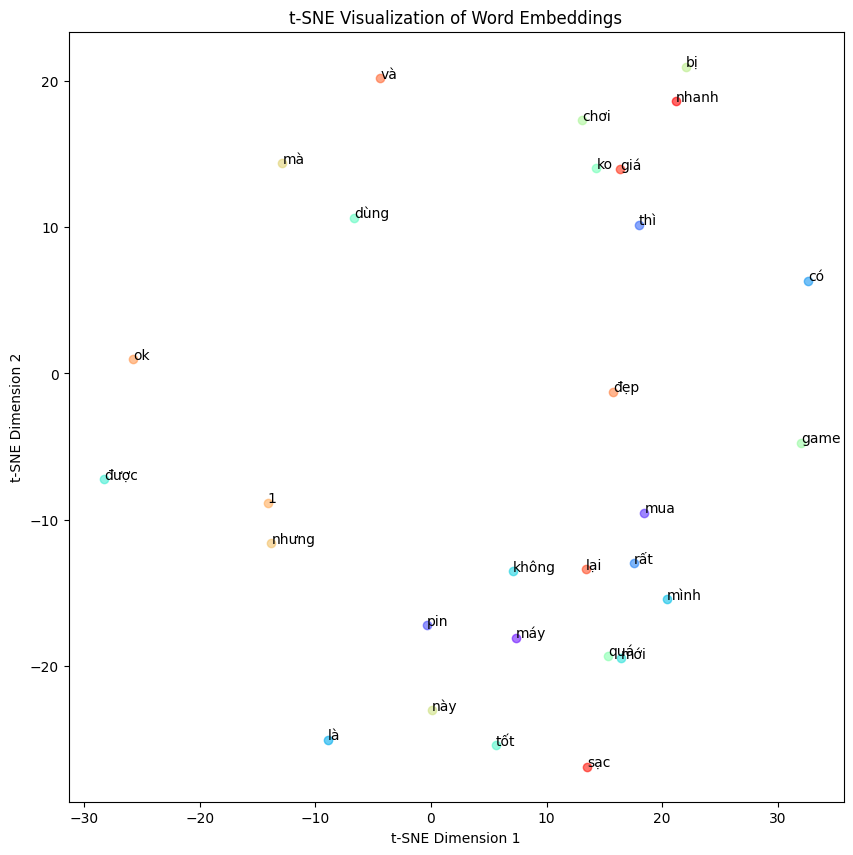

In [211]:
# Vẽ trực quan hóa với nhãn từ
# Màu cho mỗi từ
colors = plt.cm.rainbow(np.linspace(0, 1, 30))
plt.figure(figsize=(10, 10))
for i in range(1,30):  
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], marker='o', color=colors[i], alpha=0.6)
    plt.annotate(df_train_corpus.index_word[i+1], (embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of Word Embeddings')
plt.show()


### 3.5 Evaluation 

> Data Preprocessing sample

In [212]:
def Preprocessing(sentence):
    sentence=ViTokenizer.tokenize(sentence)
    sentence=df_train_corpus.texts_to_sequences([sentence])
    sentence = Padding(sentence)
    return sentence

> Generate 20 word

In [213]:
next_words = 20
seed_text="Trường Đại học Sư phạm Kỹ thuật TP HCM với 53 năm xây dựng và phát triển đã đào tạo"
y_predict=[]
def Recommend(seed_text):
    for _ in range(next_words):
        token_list = Preprocessing(seed_text.lower())
        predicted_probs = model_generate.predict(token_list)
        predicted_word = df_train_corpus.index_word[np.argmax(predicted_probs)]
        seed_text += " " + predicted_word
        y_predict.append(predicted_word)
    return seed_text


> Recommend text

In [214]:
y_result=Recommend(seed_text)
print(y_result)
print(y_predict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Trường Đại học Sư phạm Kỹ thuật TP HCM với 53 năm xây dựng và phát triển đã đào tạo rồi <oov> xứng đáng giá 25trđứng vững luôn định quyết sô tiền ra mua và rẻ iphone mua cùng thất
['rồi', '<oov>', 'xứng', 'đáng', 'giá', '25trđứng', 'vững',

#### 3.5 Evaluating 

In [215]:
# y_true = ["came","to","Vietnam","to","find","a","reliable","partner", "to","receive"]
# accuracy = accuracy_score(y_true, y_predict)
# print(f'Accuracy: {accuracy:.4f}')

# precision = precision_score(y_true, y_predict, average='weighted')
# print(f"Precision: {precision:.4f}")

# recall = recall_score(y_true, y_predict, average='weighted')
# print(f"Recall: {recall:.4f}")

# f1score = f1_score(y_true, y_predict, average='weighted')
# print(f"F1-score: {f1score}")